In [66]:
# Author: James Meehan
# Date: 8/15/18
# Description: Machine Learning Model to predict fantasy running back scores on a weekly basis
# Cepheus Capstone Project

# import libraries
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
from sklearn import preprocessing

In [67]:
# pull in data and separate between data stack, labels, and actual scores
df = pd.read_csv('RBRev2.csv', sep=',', )
pts_targets = df
labels = df

labels = labels.loc[0:, 'fname':'actual']
labels = labels.values

df = df.loc[0:, 'def rating':'retd_2wk']
pts_targets = pts_targets.loc[0:, 'actual']

df = df.values
df.shape

(2125, 30)

In [68]:
# normalize the inputs
scaled_inputs = preprocessing.scale(df)
print(scaled_inputs)

samples_count = scaled_inputs.shape[0]

# split into test and training groups
train_samples = int(0.8*samples_count)
test_samples = int(samples_count - train_samples)

train_inputs = scaled_inputs[:train_samples]
train_targets = pts_targets[:train_samples]

test_inputs = scaled_inputs[train_samples:]
test_targets = pts_targets[train_samples:]

[[ 7.09455998e-01 -9.99529522e-01 -1.12877479e-14 ...  1.31455151e+00
   2.33242470e+00 -3.06202634e-01]
 [-9.49215309e-01 -9.99529522e-01  9.03074264e-01 ... -1.08735903e+00
  -8.57199421e-01 -3.06202634e-01]
 [ 2.94788171e-01 -9.99529522e-01 -1.12877479e-14 ... -1.08735903e+00
  -8.57199421e-01 -3.06202634e-01]
 ...
 [-2.58102265e-01 -9.99529522e-01 -1.12877479e-14 ...  8.34169403e-01
  -1.28142479e-01 -3.06202634e-01]
 [ 9.85901216e-01  1.00047070e+00 -3.56189197e-01 ...  3.53787294e-01
  -3.10406714e-01 -3.06202634e-01]
 [ 1.83429533e-02  1.00047070e+00 -1.12877479e-14 ...  1.79493362e+00
   9.65442934e-01 -3.06202634e-01]]


In [69]:
print("Training set: {}".format(train_inputs.shape))  # 1700 examples, 30 features
print("Testing set:  {}".format(test_inputs.shape))   # 425 examples, 30 features

Training set: (1700, 30)
Testing set:  (425, 30)


In [70]:
# build the neural network.  Testing and refining the model found a nueral net with 1 hidden layer and 40 neurons
# produces the best results
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(40, activation=tf.nn.relu, 
                       input_shape=(train_inputs.shape[1],)),
    keras.layers.Dense(1)
  ])
  #AdamOptimizer
  optimizer = tf.train.AdamOptimizer(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 40)                1240      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 41        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [71]:
# Display training progress by printing a single dot for each completed epoch.
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 50

# Store training stats
history = model.fit(train_inputs, train_targets, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])


..................................................

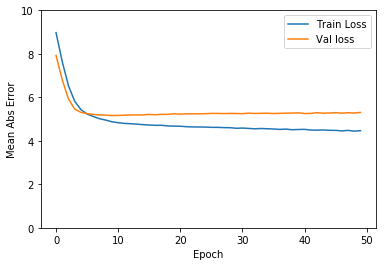

In [72]:
# Graph Training
import matplotlib.pyplot as plt

def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(history.epoch, np.array(history.history['mean_absolute_error']), 
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0,10])

plot_history(history)

In [73]:
# calculate performance
[loss, mae] = model.evaluate(test_inputs, test_targets, verbose=0)

print("Testing set Mean Abs Error: {:7.2f}".format(mae))
print("Testing set Mean Squared Error: {:7.2f}".format(loss))

Testing set Mean Abs Error:    5.36
Testing set Mean Squared Error:   46.07


In [75]:
# get predictions
test_predictions = model.predict(test_inputs).flatten()

print(test_predictions)

[15.451147  18.910769   9.710599   7.348944  15.2755995  8.693133
  6.219872   4.912357  15.458001   9.354093   8.501149   8.592387
  6.5960436  8.903409  13.478211   9.555711   7.543218   9.271388
 10.493764   7.8837748 11.48593    6.757939   6.3514333 12.255751
  6.446478   8.502384   7.6515937 15.799789   8.195187   7.636404
 15.09889   13.684613   6.782131  11.002694  14.574298  17.531097
  9.239525   7.1459613 21.343166   9.354415  11.682775   8.41154
 14.588841   6.7112813 10.365401   7.997482   8.920121   4.281164
 11.542747   7.539702   7.259921   8.38235   10.027513   6.0590444
  9.195873  13.673568   7.4356165  5.9956865 13.250648   6.389977
  6.436008   3.7624621  9.615973  16.953194  10.095072  11.002863
 11.161364  13.302426  11.841402  16.786827  19.57733   12.229119
  6.8888497 12.000054   5.7625737 17.694622   7.9600625  6.1657767
  7.4623    12.738286   9.380396   8.368673  10.77567    5.29062
  9.9864025  8.200966   6.0873895  7.5554256  6.08581    8.356991
  8.27218 

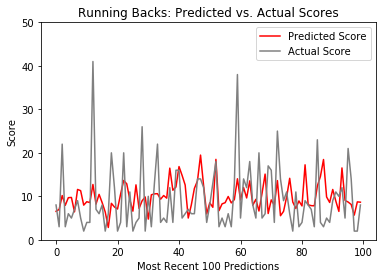

In [91]:
# Graph Predicted vs. Actual Scores
def plot_predict():
  plt.figure()
  plt.title('Running Backs: Predicted vs. Actual Scores')
  plt.xlabel('Most Recent 100 Predictions')
  plt.ylabel('Score')
  plt.plot(np.array(test_predictions[325:425]), label = "Predicted Score", color="red")
  plt.plot(np.array(test_targets[325:425]), label = "Actual Score", color="grey")
  plt.legend()
  plt.ylim([0,50])

plot_predict()

In [12]:
RBtest_labels = labels[train_samples:]

In [13]:
fullList = []

for i in range(len(test_predictions)):
    mylist = []
    mylist.append(RBtest_labels[i][0])
    mylist.append(RBtest_labels[i][1])
    mylist.append(RBtest_labels[i][2])
    mylist.append(RBtest_labels[i][3])
    mylist.append(RBtest_labels[i][4])
    mylist.append(test_predictions[i])
    fullList.append(mylist)
print (fullList)

[[' Leonard', ' Fournette', 6, 2017, 19, 17.191076], [' LeVeon', ' Bell', 6, 2017, 24, 20.514101], [' Marshawn', ' Lynch', 6, 2017, 6, 11.458319], [' Matt', ' Breida', 6, 2017, 3, 7.200842], [' Melvin', ' Gordon', 6, 2017, 26, 15.29441], [' Mike', ' Gillislee', 6, 2017, 3, 11.406383], [' Tarik', ' Cohen', 6, 2017, 9, 7.876589], [' Theo', ' Riddick', 6, 2017, 4, 5.584163], [' Todd', ' Gurley', 6, 2017, 11, 12.808563], [' Wayne', ' Gallman', 6, 2017, 2, 14.627193], [' Aaron', ' Jones', 7, 2017, 19, 7.2561355], [' Alex', ' Collins', 7, 2017, 3, 7.5501585], [' Austin', ' Ekeler', 7, 2017, 9, 7.2150564], [' Carlos', ' Hyde', 7, 2017, 8, 9.148771], [' Chris', ' Ivory', 7, 2017, 9, 13.170745], [' Christian', ' McCaffrey', 7, 2017, 4, 12.950421], [' Corey', ' Clement', 7, 2017, 6, 7.413082], [' DeMarco', ' Murray', 7, 2017, 6, 8.644205], [' Derrick', ' Henry', 7, 2017, 2, 12.561244], [' Dion', ' Lewis', 7, 2017, 7, 9.479082], [' Doug', ' Martin', 7, 2017, 7, 8.252127], [' Duke', ' Johnson', 7,

In [14]:
import csv
from pandas import read_csv 

with open("RBtestOutput.csv","w",newline="") as newFile: 
    cw = csv.writer(newFile, delimiter=',')
    for i in fullList:
        cw.writerow(i)
        
Rbformat = read_csv('RBtestOutput.csv', sep=',')
Rbformat.columns = ['fname', 'lname', 'week', 'yr', 'actual', 'predicted']
Rbformat.values[Rbformat.values[0][0] == " Le'Veon"] = ' LeVeon,'
        
Rbformat.to_csv('RBtestOutput.csv', index=False)

In [15]:
import psycopg2
conn = psycopg2.connect(database="Cepheus_db",
                        user="db_usr",
                        password="B3av3rs1!",
                        host="osucepheus.cgwruhobay1w.us-east-2.rds.amazonaws.com",
                        port="5432")

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [16]:
#Create cursor with which to execute queries
cur = conn.cursor()

In [17]:
#parse csv
with open ('RBtestOutput.csv') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=',')
    for row in reader:
        #build query string
        query1 = 'INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES '
        query2 =row['fname'], row['lname'], row['week'], row['yr'], row['actual'], row['predicted']
        query = str(query1) + str(query2)
        print(query)
        #execute query
        cur.execute(query)
#commit change
conn.commit()

INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' LeVeon', ' Bell', '6', '2017', '24', '20.514101')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Marshawn', ' Lynch', '6', '2017', '6', '11.458319')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Matt', ' Breida', '6', '2017', '3', '7.200842')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Melvin', ' Gordon', '6', '2017', '26', '15.294410000000001')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Mike', ' Gillislee', '6', '2017', '3', '11.406383')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Tarik', ' Cohen', '6', '2017', '9', '7.876589')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Theo', ' Riddick', '6', '2017', '4', '5.584162999999999')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Todd', ' Gurley', '6', 

INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' LeVeon', ' Bell', '12', '2017', '16', '20.347002')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Mark', ' Ingram', '12', '2017', '3', '11.665353')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Melvin', ' Gordon', '12', '2017', '8', '13.431526999999999')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Orleans', ' Darkwa', '12', '2017', '3', '7.338374000000001')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Peyton', ' Barber', '12', '2017', '12', '7.521164999999999')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Rex', ' Burkhead', '12', '2017', '17', '13.035178')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Rod', ' Smith', '12', '2017', '10', '7.933347')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Samaje',

INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Derrick', ' Henry', '14', '2017', '8', '6.817664')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Devontae', ' Booker', '14', '2017', '3', '13.86955')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Dion', ' Lewis', '14', '2017', '6', '9.13504')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Duke', ' Johnson', '14', '2017', '10', '10.187439999999999')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Frank', ' Gore', '14', '2017', '14', '6.450162000000001')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Giovani', ' Bernard', '14', '2017', '12', '11.0232315')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Isaiah', ' Crowell', '14', '2017', '13', '11.824653999999999')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Jam

INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Todd', ' Gurley', '16', '2017', '38', '15.181614999999999')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Wayne', ' Gallman', '16', '2017', '5', '8.241168')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Alex', ' Collins', '17', '2017', '14', '12.166356')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Alfred', ' Blue', '17', '2017', '12', '7.904725599999999')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Alvin', ' Kamara', '17', '2017', '18', '18.555992')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Ameer', ' Abdullah', '17', '2017', '8', '9.290174')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Bilal', ' Powell', '17', '2017', '5', '6.8316355')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Carlos', ' Hyde

In [18]:
# import training data
training_predictions = model.predict(train_inputs).flatten()
#training_predictions.shape

In [19]:
trainList = []

for i in range(480, 1700):
    mylist = []
    mylist.append(labels[i][0])
    mylist.append(labels[i][1])
    mylist.append(labels[i][2])
    mylist.append(labels[i][3])
    mylist.append(labels[i][4])
    mylist.append(training_predictions[i])
    trainList.append(mylist)
print (trainList)

[[' Adrian', ' Peterson', 3, 2015, 24, 22.248642], [' Alfred', ' Blue', 3, 2015, 19, 7.546841], [' Ameer', ' Abdullah', 3, 2015, 9, 10.299272], [' Andre', ' Williams', 3, 2015, 8, 9.684749], [' Bilal', ' Powell', 3, 2015, 7, 8.249335], [' Bishop', ' Sankey', 3, 2015, 4, 5.842457], [' Carlos', ' Hyde', 3, 2015, 6, 7.070551], [' Charles', ' Sims', 3, 2015, 11, 5.2958784], [' Chris', ' Thompson', 3, 2015, 13, 4.9329343], [' Chris', ' Johnson', 3, 2015, 27, 15.578882], [' Danny', ' Woodhead', 3, 2015, 4, 8.9272], [' Darren', ' Sproles', 3, 2015, 8, 5.481839], [' Darren', ' McFadden', 3, 2015, 9, 10.833019], [' David', ' Johnson', 3, 2015, 3, 6.5831637], [' Devonta', ' Freeman', 3, 2015, 37, 12.006216], [' Dexter', ' McCluster', 3, 2015, 3, 6.2820253], [' Dion', ' Lewis', 3, 2015, 12, 14.1546755], [' Doug', ' Martin', 3, 2015, 4, 8.45076], [' Duke', ' Johnson', 3, 2015, 3, 11.218305], [' Eddie', ' Lacy', 3, 2015, 8, 11.87176], [' Frank', ' Gore', 3, 2015, 20, 10.193944], [' Giovani', ' Bern

In [20]:
import csv
from pandas import read_csv 

with open("RBtrainOutput.csv","w",newline="") as newFile: 
    cw = csv.writer(newFile, delimiter=',')
    for i in trainList:
        cw.writerow(i)
        
RBformat = read_csv('RBtrainOutput.csv', sep=',')
RBformat.columns = ['fname', 'lname', 'week', 'yr', 'actual', 'predicted']
        
RBformat.to_csv('RBtrainOutput.csv', index=False)

In [21]:
# put training predict data into database
#Create cursor with which to execute queries
cur = conn.cursor()

#parse csv
with open ('RBtrainOutput.csv') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=',')
    for row in reader:
        #build query string
        query1 = 'INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES '
        query2 =row['fname'], row['lname'], row['week'], row['yr'], row['actual'], row['predicted']
        query = str(query1) + str(query2)
        print(query)
        #execute query
        cur.execute(query)
#commit change
conn.commit()

INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Alfred', ' Blue', '3', '2015', '19', '7.546841000000001')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Ameer', ' Abdullah', '3', '2015', '9', '10.299272')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Andre', ' Williams', '3', '2015', '8', '9.684749')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Bilal', ' Powell', '3', '2015', '7', '8.249335')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Bishop', ' Sankey', '3', '2015', '4', '5.842457')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Carlos', ' Hyde', '3', '2015', '6', '7.070550999999999')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Charles', ' Sims', '3', '2015', '11', '5.2958784')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Chris', ' Thompson', '3'

INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Carlos', ' Hyde', '7', '2015', '4', '7.222141000000001')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Charcandrick', ' West', '7', '2015', '18', '8.55822')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Chris', ' Johnson', '7', '2015', '18', '15.428839000000002')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' CJ', ' Spiller', '7', '2015', '4', '9.98368')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Danny', ' Woodhead', '7', '2015', '21', '15.871179000000001')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Darren', ' Sproles', '7', '2015', '3', '5.039541000000001')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' DeMarco', ' Murray', '7', '2015', '6', '4.538505000000001')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VA

INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Jay', ' Ajayi', '11', '2015', '3', '9.579369999999999')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Jeremy', ' Langford', '11', '2015', '9', '10.526558')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Jeremy', ' Hill', '11', '2015', '16', '11.736313')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Jonathan', ' Stewart', '11', '2015', '17', '12.091494')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' KaDeem', ' Carey', '11', '2015', '3', '8.859358')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Lamar', ' Miller', '11', '2015', '5', '9.7748575')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Latavius', ' Murray', '11', '2015', '8', '9.066527')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' LeGarrette', ' Blount

INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Darren', ' McFadden', '14', '2015', '11', '9.606065')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' David', ' Johnson', '14', '2015', '12', '4.7877126')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' DeAngelo', ' Williams', '14', '2015', '20', '18.285120000000003')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' DeMarco', ' Murray', '14', '2015', '3', '9.591913')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Doug', ' Martin', '14', '2015', '14', '11.464818')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Duke', ' Johnson', '14', '2015', '7', '8.381705')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Eddie', ' Lacy', '14', '2015', '20', '18.145101999999998')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Frank',

INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' James', ' White', '16', '2015', '8', '8.901100999999999')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Javorius', ' Allen', '16', '2015', '16', '8.189634')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Jay', ' Ajayi', '16', '2015', '2', '8.737233')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Jeremy', ' Hill', '16', '2015', '6', '7.8639755000000005')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Jeremy', ' Langford', '16', '2015', '8', '5.481895')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Jerick', ' McKinnon', '16', '2015', '20', '9.476733')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Joique', ' Bell', '16', '2015', '7', '12.26929')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Jonathan', ' Grimes

INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' LeGarrette', ' Blount', '3', '2016', '22', '13.287513')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' LeSean', ' McCoy', '3', '2016', '23', '17.564116000000002')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Mark', ' Ingram', '3', '2016', '18', '15.623098')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Matt', ' Forte', '3', '2016', '6', '7.9815507')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Matt', ' Jones', '3', '2016', '7', '8.024989')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Melvin', ' Gordon', '3', '2016', '13', '16.07033')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Mike', ' Gillislee', '3', '2016', '2', '4.853445')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Robert', ' Turbin', '3', '201

INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Carlos', ' Hyde', '6', '2016', '5', '10.786005000000001')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Chris', ' Thompson', '6', '2016', '5', '2.492466')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' CJ', ' Anderson', '6', '2016', '6', '7.2607985')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Damien', ' Williams', '6', '2016', '7', '6.2485404')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' David', ' Johnson', '6', '2016', '31', '23.158663')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' DeAndre', ' Washington', '6', '2016', '4', '6.2358484')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' DeMarco', ' Murray', '6', '2016', '12', '17.228195')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Derrick', ' Henry', 

INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Chris', ' Ivory', '9', '2016', '9', '11.050017')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Christine', ' Michael', '9', '2016', '6', '12.825485')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Darren', ' Sproles', '9', '2016', '6', '7.89562')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' DeAndre', ' Washington', '9', '2016', '3', '6.4731016')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' DeMarco', ' Murray', '9', '2016', '13', '13.308595')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Devonta', ' Freeman', '9', '2016', '9', '9.462104')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Devontae', ' Booker', '9', '2016', '2', '8.026337')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Duke', ' Johnson', '9', '

INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Dion', ' Lewis', '13', '2016', '3', '6.701506')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Doug', ' Martin', '13', '2016', '12', '13.326994000000001')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Dwayne', ' Washington', '13', '2016', '3', '7.9028089999999995')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Ezekiel', ' Elliott', '13', '2016', '15', '12.076794999999999')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Frank', ' Gore', '13', '2016', '7', '12.713538')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Jalen', ' Richard', '13', '2016', '5', '6.784608')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' James', ' White', '13', '2016', '2', '3.8578546')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Jay',

INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Latavius', ' Murray', '15', '2016', '8', '8.4542465')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' LeGarrette', ' Blount', '15', '2016', '9', '10.100514')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' LeSean', ' McCoy', '15', '2016', '28', '25.696207')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' LeVeon', ' Bell', '15', '2016', '12', '25.492777')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Mark', ' Ingram', '15', '2016', '8', '10.121035000000001')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Matt', ' Asiata', '15', '2016', '2', '12.097547')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Matt', ' Forte', '15', '2016', '2', '13.916892')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Mike', ' Gillislee', 

INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Terrance', ' West', '17', '2016', '2', '9.128395')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Tevin', ' Coleman', '17', '2016', '11', '16.774588')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Thomas', ' Rawls', '17', '2016', '7', '10.457215')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Tim', ' Hightower', '17', '2016', '8', '9.171407')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Todd', ' Gurley', '17', '2016', '7', '16.02854')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Travaris', ' Cadet', '17', '2016', '7', '5.8486958')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Zach', ' Zenner', '17', '2016', '16', '10.428269')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Alvin', ' Kamara', '3', '2017', '

INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Tarik', ' Cohen', '4', '2017', '4', '10.830506')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Tevin', ' Coleman', '4', '2017', '13', '9.985036000000001')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Todd', ' Gurley', '4', '2017', '27', '15.637832000000001')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Ty', ' Montgomery', '4', '2017', '2', '10.15726')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Wendell', ' Smallwood', '4', '2017', '13', '9.974889')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Alex', ' Collins', '5', '2017', '5', '7.108639200000001')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Ameer', ' Abdullah', '5', '2017', '3', '12.436534')
INSERT INTO rb_results(fname, lname, week, yr, actual, predicted) VALUES (' Andre', '